# ROOT LOCUS ANALYSIS

One approach to designing a closed loop system is to design the controller so as to achieve desired poles of the closed loop for the following objectives:
* stability
* short settling times
* no oscillations

A root locus plot shows the relationship between a controller parameter, its open loop poles and zeroes, and its closed loop poles.

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install control
    !pip -q install tellurium

In [2]:
import collections
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
kP = 1
kI =1
setpoint = 1
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
tf = k1*k2/(s*(s+k2))

In [6]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model. 

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       ExtendedRoadrunner
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = float(value)
    if selections is None:
        rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return rr

# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
print("OK!")

OK!


In [7]:
Parameters = collections.namedtuple("Parameters", "k1 k2 k3 S1 kP kI, setpoint")
def getParameters(model, **kwargs):
    """
    Retrieves constants used in the open and closed loop models.
    
    Args:
        model: str/Roadrunner
        kwargs: values to assign in the model
        
    Returns:
        Parameters
    """
    def get(name):
        if name in rr.keys():
            return rr[name]
        return 0
    #
    if isinstance(model, str):
        rr = te.loada(model)
    else:
        rr = model
    for key, value in kwargs.items():
        rr[key] = float(value)
    #
    parameters = Parameters(
        k1=get("k1"),
        k2=get("k2"),
        k3=get("k3"),
        setpoint=get("setpoint"),
        kP=get("kP"),
        kI=get("kI"),
        S1=get("S1"),
    )
    return parameters

# Tests
parameters = getParameters(model=TEST_MODEL, k1=4)
assert(isinstance(parameters, Parameters))
print("OK!")
    

OK!


In [8]:
def makeTransferFunctions(model, **kwargs):
    """
    Constructs the open loop and closed loop transfer functions for MODEL1.
    
    Args:
        model: roadrunner or antimony
        kwargs: values to use in transfer function that differ from the model.
    """
    p = getParameters(model, **kwargs)
    ol_tf = p.k1*p.k2/((s + p.k2)*(s+ p.k3))
    controller_tf = p.kP + p.kI/s
    cl_tf = control.feedback(ol_tf*controller_tf)
    return ol_tf, cl_tf

# TESTS
ol_tf, cl_tf = makeTransferFunctions(TEST_MODEL, k3=2)
assert(isinstance(ol_tf, control.TransferFunction))
assert(isinstance(cl_tf, control.TransferFunction))
print("OK!")

OK!


In [9]:
def plotPoles(model, kPs=0, kIs=0, xlim=None, is_plot=True):
    """
    Plots the open loop poles and zeroes and closed loop poles for the model.
    
    Args:
        model: antimony or roadrunner
        kPs: list/float
        kIs: list/float
        xlim: tuple (limits of x-axis on plot)
        
    Returns:
        control.TransferFunction (open loop)
        control.TransferFunction (closed loop)
    """
    p = getParameters(model)
    if isinstance(kPs, int) or isinstance(kPs, float):
        kPs = [kPs]
    if isinstance(kIs, int) or isinstance(kIs, float):
        kIs = [kIs]
    if len(kPs) == 1:
        kPs = np.repeat(kPs[0], len(kIs))
    if len(kIs) == 1:
        kIs = np.repeat(kIs[0], len(kPs))
    #
    annotations = []
    cl_poles = []
    for kI in kIs:
        for kP in kPs:
            ol_tf, cl_tf = makeTransferFunctions(model, kP=kP, kI=kI)
            for pole in cl_tf.poles():
                annotations.append("%2.2f, %2.2f" % (kP, kI))
                cl_poles.append(pole)
    annotations.extend(annotations)
    cl_poles = np.array(cl_poles)
    if is_plot:
        _, ax = plt.subplots(1)
        ol_poles = ol_tf.poles()
        ax.scatter(ol_poles.real, ol_poles.imag, marker="o", c="red")
        ax.scatter(cl_poles.real, cl_poles.imag, marker="*", c="blue")
        _ = [ax.annotate(t, (p.real, p.imag), fontsize=8) for t, p in zip(annotations, cl_poles)]
        ax.set_xlabel("Real")
        ax.set_ylabel("Imaginary")
        _ = ax.set_title("Open and closed loop poles for kP, kI.")
        if xlim is not None:
            ax.set_xlim(xlim)
    
# Tests
plotPoles(TEST_MODEL, kPs=[0.01, 0.1, 10, 100], is_plot=False)
print("OK!")

OK!


# Dominant poles

A dominant pole is a pole whose real part is at least a factor of 10 closer to 0 than the other poles. The pole is dominant in the sense that the dynamics are largely due to that pole.

In [10]:
def plotTransferFunctions(tf1, tf2, title=""):
    """
    Compares the two transfer functions
    """
    _, predictions1 = control.forced_response(tf1, T=TIMES, U=1)
    _, predictions2 = control.forced_response(tf2, T=TIMES, U=1)
    plt.plot(TIMES, predictions1)
    plt.plot(TIMES, predictions2)
    plt.legend([str(tf1), str(tf2)])
    plt.title(title)

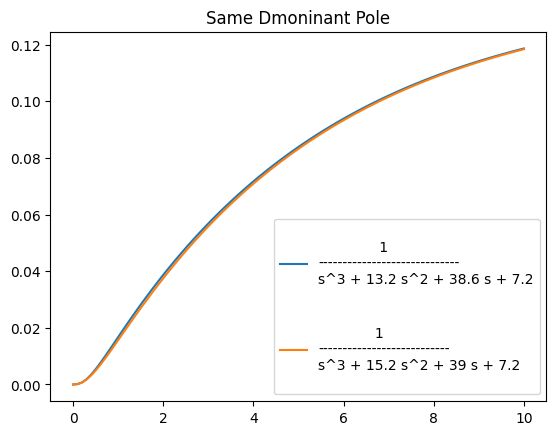

In [11]:
# 0.2 is a dominant pole for both transfer functions
tf1 = 1/((s +9)*(s + 4)*(s + 0.2))
tf2 = 1/((s +12)*(s + 3)*(s + 0.2))
plotTransferFunctions(tf1, tf2, title="Same Dmoninant Pole")

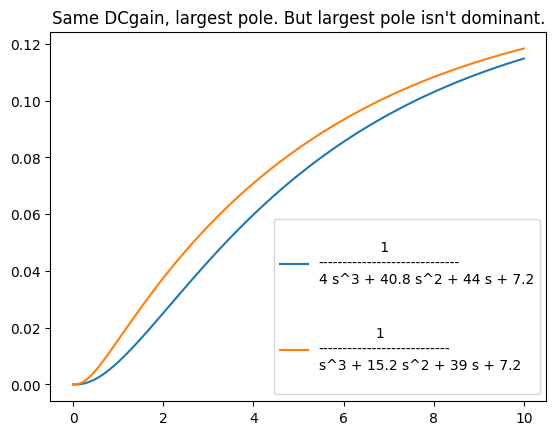

In [12]:
# 0.2 is a dominant pole for both transfer functions, but 0.2 is not dominant for one
tf1 = 1/(4*(s +9)*(s + 1)*(s + 0.2))
tf2 = 1/((s +12)*(s + 3)*(s + 0.2))
plotTransferFunctions(tf1, tf2, title="Same DCgain, largest pole. But largest pole isn't dominant.")

# Analysis of pole trajectory

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/simple_feedback_nofilter.png/
     width="600">

Let $C(s)$ be the transfer function of the controller and $G(s)$ be the transfer function of the OLS.
Then, the transfer function of the closed loop is:
\begin{eqnarray}
H(s) & = & \frac{ C(s)G(s)}{1 +C(s) G(s)} \\
\end{eqnarray}

Let $G(s) = \frac{Z(s)}{P(s)}$.
\begin{eqnarray}
H(s) & = & \frac{ C(s)\frac{Z(s)}{P(s)}}{1 +C(s)\frac{Z(s)}{P(s)}} \\
& = & \frac{C(s) Z(s)}{P(s) + C(s) Z(s)} \\
\end{eqnarray}

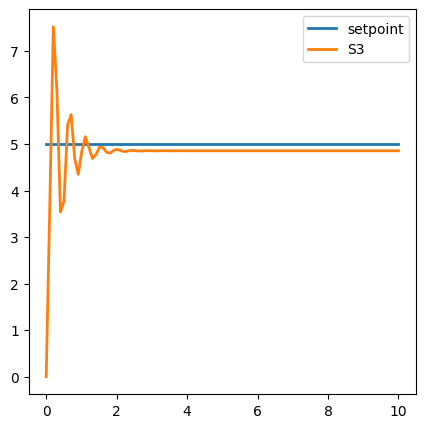

In [13]:
MODEL1 = """
// Open loop system
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S2 = 0
k1 =1
k2 = 2
k3 = 3
// ***** Feedback
// Feedback constant
setpoint = 1  # Input to the closed loop is the setpoint or reference
kP = 1  # Design parameter for P controller
kI = 0 # Design parameter for integral control
// Closed loop
control_error := setpoint - S3
integral_control_error = 0
integral_control_error' = control_error
$S1 := kP*control_error + kI*integral_control_error  # Controller implementation
"""
SETPOINT = 5
rr =plotModel(MODEL1, setpoint=SETPOINT, kP=100, selections=["setpoint", "S3"])

**Transfer Functions**

* Open loop transfer function $G(s) = \frac{k_1 k_2}{(s + k_2)(s + k_3)}$.
* Open loop zeroes: $s = ??$
* Open loop poles $s = ??$

Now let's see how the closed loop poles change as we change $k_P$.

Let $C(s) = k_P$. Then, $$H(s) = \frac{k_P Z(s)}{P(s) + k_P Z(s)}$$.

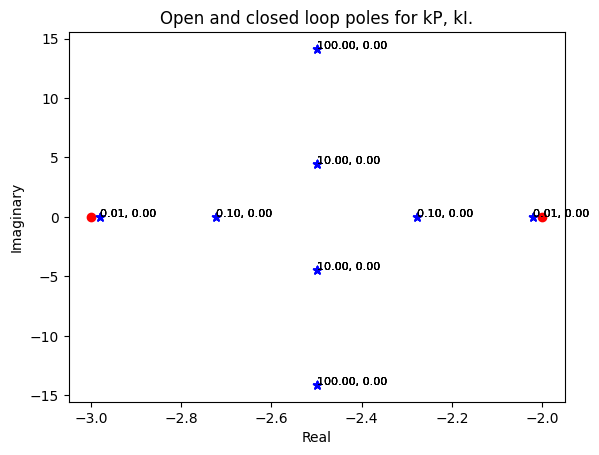

In [14]:
plotPoles(MODEL1, kPs=[0.01, 0.1, 10, 100])

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/trajectory.png/
     width="600">

**Observations**
1. There are multiple poles. Changing $
But the trajectory as we vary $k_P$ is quite different. Instead of going towards each pole, it goes away from each pole as $k_I$ increases.

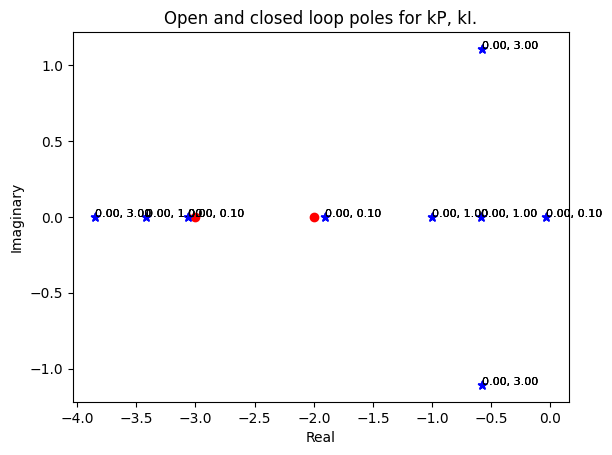

In [15]:
plotPoles(MODEL1, kIs=[0.1, 1, 3])

# Root locus plot

The root locus plot provides a way to predict the trajectory of poles as well vary design parameters.
It is limited to a single design parameter at a time: $k_P, k_I, k_D$.

The plot is in the $s$ plane. This is the complex plane. The horizontal axis is the real part
and the vertical axis is the imaginary part.
The analysis is assumes that the transfer function of the controller is $k C(s)$. For example, in proportional control, $C(s) = 1$, and $k= k_P$. For integral control, $C(s) = \frac{1}{s}$, and $k= k_I$.
$Z(s), P(s)$ are the open loop zeroes and poles. That is, the open loop transfer function is $G(s) = \frac{Z(s)}{P(s)}$.

Below is the key equation for this analysis.
\begin{eqnarray}
H(s) 
& = & \frac{k C(s) Z(s)}{P(s) + kC(s) Z(s)} \\
\end{eqnarray}

## Proportional control

\begin{eqnarray}
H(s) 
& = & \frac{k_P Z(s)}{P(s) + k_P Z(s)} \\
\end{eqnarray}

In [16]:
p = getParameters(MODEL1, kP=1)
OL_TF = p.k1*p.k2/((s + p.k2)*(s + p.k3))
OL_TF

TransferFunction(array([2.]), array([1., 5., 6.]))

In [17]:
controller_tf = p.kP
CL_TF = control.feedback(controller_tf*OL_TF)
CL_TF

TransferFunction(array([2.]), array([1., 5., 8.]))

**Questions**: 
1. How many open loop poles?
1. How many closed loop poles?

In [18]:
# Construct the system to be analyzed by root locus.
p = getParameters(model=MODEL1)
SYS_TF = p.k1*p.k2/((s + p.k2)*(s+ p.k3))

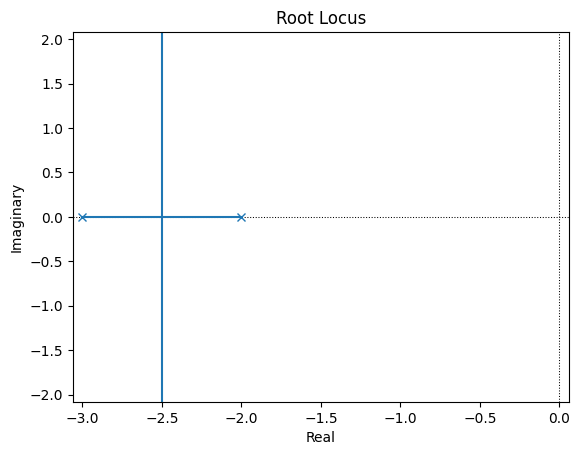

In [19]:
_ = control.root_locus(SYS_TF, grid=False)

This plot tells us in more detail what we learned in our exploration of P-control.
1. The closed loop poles start at the open loop poles indicated by the X's at -3 and -2.
1. There are two poles. As we increase $k_P$, the pole near -3 moves to the right and the pole near -2 moves to the left.
1. The two poles meet when $k_P$ is such that both poles are at -2.5. This is called the **break away** point.
1. From the break away point, further increases in $k_P$ do not affect the real part of the closed loop poles. However, the immaginary part increases.

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/trajectory.png/
     width="600">

**Questions**
1. Why does the root-locus plan have a vertical line that is symmetric about the x-axis?
1. From the foregoing, how would you choose $k_P$ if your control objectives are:
(a) minimize settling times and
(b) avoid oscillations?

## Integral control

\begin{eqnarray}
H(s) 
& = & \frac{k_I Z(s)}{s P(s) + k_I Z(s)} \\
\end{eqnarray}

In [20]:
p = getParameters(MODEL1, kP=1, kI=1)
OL_TF = p.k1*p.k2/((s + p.k2)*(s + p.k3))
OL_TF

TransferFunction(array([2.]), array([1., 5., 6.]))

In [21]:
controller_tf = p.kI/s
CL_TF = control.feedback(controller_tf*OL_TF)
CL_TF

TransferFunction(array([2.]), array([1., 5., 6., 2.]))

**Questions**: 
1. How many open loop poles?
1. How many closed loop poles?

In [22]:
# The transfer function for the root locus plot includes the 1/s in integral control.
p = getParameters(model=MODEL1)
SYS_TF = p.k1*p.k2/(s*(s + p.k2)*(s+ p.k3))

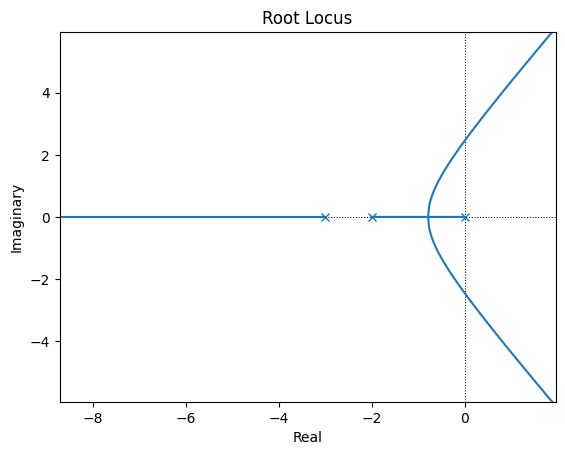

In [23]:
_ = control.root_locus(SYS_TF, grid=False)

This looks very different from P-control. Note that for some values of $k_I$ the system is unstable.

# Summary

1. Control design can be viewed as selecting values for the design parameters for: proportional control ($k_P$),
integral control ($k_I$), and the filter ($k_F$).
1. The closed loop system typically has multiple poles. Rather than trying to control all poles, it often is easier to focus on the **dominant pole**, the largest pole.
1. As the design parameters change, all poles change. Some increase, and some decease.
1. The root locus plot provides a way to see the trajectory of the closed loop poles with changes in a design parameter.